A note book for extracting ENA from trained RNNs

In [383]:
#%%
import numpy as np
import networkx as nx # for network analysis
from copy import deepcopy, copy
import random
from matplotlib import pyplot as plt
# %%
# def remove_two_loops(B):
#     '''
#     removes 2-loops 

#     2-loops are remove by severing one of the connections: the one leading to the
#     node with fewer number of outgoing direction except if the # of outgoing direction
#     is 1.  
#     '''
#     n = B.shape[0]
#     A = copy(B)
#     J = list()
#     for i in range(n):
#         for j in range(i+1, n):
#             if {i, j} not in J and A[i, j] + A[j, i] == 2:
#                 ix = [i, j]
#                 random.shuffle(ix)
#                 A[ix[0], ix[1]] = 0
#             J.append({i, j})
#     return A

def remove_two_loops(B):
    B = copy(B)
    n = B.shape[0]
    B2 = np.matmul(B, B)
    paths_of_2 = list(np.where(B2.diagonal())[0])
    index_tracker = list()
    while len(index_tracker) != len(paths_of_2):
        start = paths_of_2[0]
        end = list(np.where(B[start, :])[0])
        B[start, end] = 0
        index_tracker += [start] + end
    return B




def remove_delta_cliques(B):
    '''
    removes delta cliques by removing the shortest connnection between the nodes
    involved
    '''
    A = deepcopy(B)
    A2 = np.bool_(np.matmul(A, A))
    if A2.sum() != 0:
        indx = np.where(A + A2 == 2)
        A[indx[0], indx[1]] = 0
    return A

def in_neighbours(i, A):
    '''
    returns the in-neihbours of i using the adjacency matrix A
    '''
    return np.where(A[:, i-1])[0]

def out_neighbours(i, A):
    '''
    returns the out-neihbours of i using the adjacency matrix A
    '''
    return np.where(A[i-1, :])[0]

def intersection(list1, list2):
    return list(set(list1) & set(list2))

import networkx as nx
def convert_to_nx(A):
    '''
    converts A into a networkx digraph
    '''
    G = nx.DiGraph(directed=True)
    out = list()
    n = A.shape[0]
    # letters provide labelling
    LETTERS = [str(i) for i in range(n)]
    for i in range(n):
        out.extend([(LETTERS[i], LETTERS[k]) for k in np.where(A[i, :])[0]])
    G.add_edges_from(out)
    return G


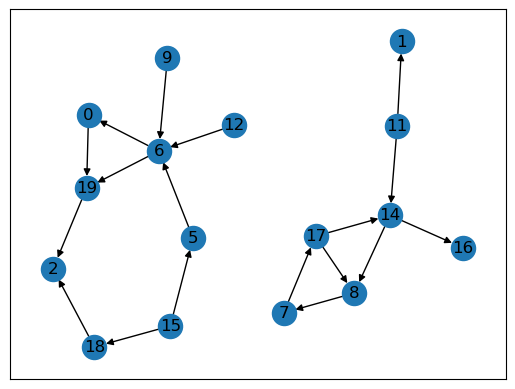

In [384]:
#%%
A = np.array([
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0]])

B = remove_delta_cliques(A)


#%%
rnn_size = 20
sparsity = 0.9 * 1/rnn_size
A = np.random.binomial(1, sparsity, (rnn_size, rnn_size))
np.fill_diagonal(A, 0)
A = remove_two_loops(A)
# print(A)
#%%
G = convert_to_nx(A)
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

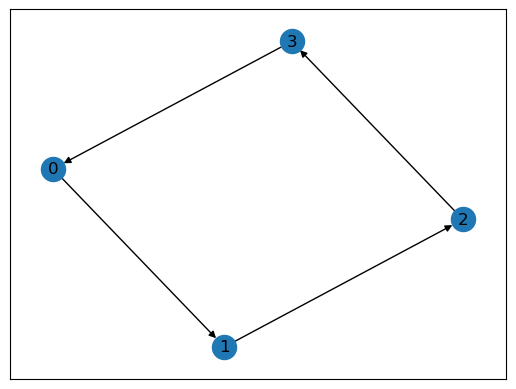

In [385]:
A = np.zeros((rnn_size, rnn_size))
A[:4, :4] = [[0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [1, 0, 0, 0]]
G = convert_to_nx(A)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
# %%
A = np.array([
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0]])

In [386]:
import torch
from generate_flip_flop import *
import pickle
with open('params.pkl', 'rb') as f:
    params = pickle.load(f)

keys = list(params.keys())
reservoir = params[keys[0]]
ridge = params[keys[1]]

Wr, Win, Wfb = torch.tensor(reservoir['W'].toarray()), \
                       torch.tensor(reservoir['Win'].toarray()), \
                       torch.tensor(reservoir['Wfb'].toarray())
# Wout = ridge['Wout']

In [387]:
# testing model
amplitude = 1.0
with open('train_test.pkl', 'rb') as f:
    x_train, y_train = pickle.load(f)
x_train = amplitude*x_train
y_train = amplitude*y_train

In [388]:
seed = 42
from reservoirpy.nodes import Reservoir, Ridge
n_neurons = 700
reservoir = Reservoir(n_neurons, sr=0.5, rc_connectivity=0.05, lr = 1, 
        input_bias=False, seed=42)
readout = Ridge(ridge=1e-4, input_bias=False)
# This force learning uses a single layer online neural network. 
# readout = FORCE(alpha=1e-6)


reservoir <<= readout  ## feedback
esn = reservoir >> readout
esn = esn.fit(x_train, y_train)

# readout.Wout = Wout
# reservoir.Wfb = Wfb
# reservoir.W = Wr

Running Model-1: 1755it [00:00, 1892.14it/s]<?, ?it/s]
Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
preds = esn.run(x_train)

In [ ]:
n_start = 0
n_steps = 4000
d = 0
plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
# plt.subplot(2, 1, 1)
# plt.plot(x_train[n_start:(n_start + n_steps), d], 'r-', label = 'input')
# plt.legend()
# plt.show()
# plt.subplot(2, 1, 2)
plt.plot(y_train[n_start:(n_start + n_steps), d], label='output')
plt.legend()
plt.show()

In [ ]:
N_new = 10000
x_new, y_new, _ = sequence(N_new, 0.03, 1, 1)
x_new = amplitude*x_new
y_new = amplitude*y_new

In [ ]:
pred_new_data = esn.run(x_new)

In [ ]:
n_start = 0
# n_steps = x_test.shape[0]
n_steps = 2000
d = 0
plt.plot(pred_new_data[n_start:(n_start + n_steps), d], label='predictions')
plt.plot(y_new[n_start:(n_start + n_steps), d], label='actual', linestyle='--')
# plt.plot(x_new[n_start:(n_start + n_steps), d], label='input', linestyle='-.')
# plt.plot(x_train[n_start:(n_start + n_steps), d], label = 'input', linestyle='-.')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn

def weight_matrix(A, p, w_p):
    w_m, w_s, w_t = p
    return w_s + (w_s - w_t)*torch.eye(A.shape[0]) + (w_p - w_t)*A.T + (w_m - w_t)*A

def activation(x, beta):
    return 1/(1+torch.exp(-beta*(x-0.5)))

def cutt_off(x):
    cond1 = x <= 0
    cond2 = x > 0
    x[cond1] = 0
    x[cond2] =  torch.exp(-1/x[cond2])
    return x

def ps_activation(x, beta):
    c = cutt_off(x)
    return c/(c + cutt_off(1-x))

def closest_direction(x):
    res = torch.zeros_like(x)
    ix = torch.argmax(x)
    res[:, ix] = 1
    return res
def max(x, y):
    return torch.tensor([x, y]).max()



In [667]:
one = torch.tensor([1.0]).requires_grad_()
minus_one = (-1*torch.tensor([1.0])).requires_grad_()
class ENA_extractor(nn.Module):
    def __init__(self, k, beta_init, p_init, Wp, n_out, n_in, scalings, A, x_init, act_fun):
        '''
        n: dimension of phase space
        beta_init: initial value of the gain parameter in 
                
                y = 1/(1+exp(-beta*x))
        p_init: contain the initial values of floats w_m, w_p, w_s, w_t in that
        order.
        A: gives the adjacency matrix
        scalings: contained scalings for Win, Wout, Wfb in that other
        '''
        super().__init__()
        # if A is None:
        #     A = np.random.binomial(1, sparsity, (n,n))
        #     np.fill_diagonal(A, 0)
        #     A = remove_two_loops(A)
        # self.s_out = torch.nn.Parameter(s_out.requires_grad_())
        self.act_fun = act_fun
        self.x = x_init
        self.A = A
        self.n = A.shape[0]
        self.n_in = n_in
        self.n_out = n_out
        self.scalings = torch.nn.Parameter(scalings.requires_grad_())
        # self.scalings = scalings
        # self.p = torch.nn.Parameter(p_init.requires_grad_())
        self.p = p_init
        # print(beta_init)
        self.beta = torch.nn.Parameter(beta_init.requires_grad_())
        # self.beta = beta_init
        # self.beta = torch.nn.Parameter(beta_init)
        # self.Win = torch.nn.Parameter((torch.randn(k, n_in)).requires_grad_())
        self.Win = torch.randn(k, n_in)
        # self.Wout = torch.nn.Parameter(torch.randn(k, n_out).requires_grad_())
        self.Wout = torch.randn(k, n_out)
        self.Wp = torch.nn.Parameter(Wp.requires_grad_())
        # self.bias = 0.001*torch.randn(1, n_out)
        self.bias = torch.nn.Parameter((0.001*torch.randn(1, n_out)).requires_grad_())
        # self.Wfb = torch.randn(n_out, k)
        self.Wfb = torch.zeros((n_out, k))
        # self.y = torch.tensor([1.0], dtype=torch.float64).requires_grad_()
        # self.Wfb = torch.nn.Parameter((torch.randn(n_out, k)).requires_grad_())
    def forward(self, X_input, y_prev, 
                state_dict = {0:minus_one, 1:one, 2:minus_one, 3:one}, h = 1):
        '''
        '''
        # scalings of weight matrices
        # s_in, s_out, s_fb = self.scalings
        s_in, s_out = self.scalings
        Wout = s_out*self.Wout
        # s_out = self.s_out
        bias = self.bias
        # number of nodes in the ENA
        n = self.n
        # weight matrices
        Win = s_in*self.Win
        # Wfb = s_fb*self.Wfb
        # gain parameter
        beta = self.beta
        # Wp control transitions
        # Wp = self.Wp
        # A is the adjacency matrix
        # A = self.A
        # p contains other parameters like w_s, w_t and w_m
        # p = self.p
        # w_m, w_s, w_t = self.p
        # W = w_t + (w_s - w_t)*torch.eye(A.shape[0]) + (Wp - w_t)*A.T + (w_m - w_t)*A
        W = weight_matrix(self.A, self.p, self.Wp)
        x = self.x
        h_out = closest_direction(
            self.forward_euler(x, y_prev, W, Win, h, X_input, beta))
        self.x = h_out
        # print(int(h_out.argmax()))
        # ix = int(h_out.argmax())
        # x_out = s_out[ix]*state_dict[ix]
        # x_out = closest_direction(h_out)
        x_out = torch.tanh(torch.matmul(h_out, Wout.float()) + bias)
        return x_out, h_out
    def forward_euler(self, x, y_prev, W, Win, h, u, beta):
        # x_t = torch.matmul(x.float(), W)
        u_t = torch.matmul(Win.float(), u.float()).reshape(x.shape)
        # feedback = torch.matmul(y_prev.float(), Wfb).reshape(x.shape)
        # return x + h*(-x + self.act_fun(x_t + u_t, beta)) 
        # print(x)
        return x + h*(-x + torch.matmul(self.act_fun(x, beta), W) + u_t)

In [672]:
# random.seed(42)
n_out = 1
# n_in = n_neurons
n_in = 1
# n = Wr.shape[0]
k = 4
q = 0.01
A = torch.zeros(k, k)
# A = torch.tensor([[0.0, 1.], [0.0, 0.0]])
A[:4, :4] = torch.tensor([
             [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [1, 0, 0, 0]])
# A[:3, :3] = torch.tensor([
#     [0, 1, 0],
#     [0, 0, 1], 
#     [1, 0, 0]
# ])
p = torch.tensor([-0.7, 1, 0])
# Wp = 0.1*torch.ones((k, k))
Wp = 0.1*A.T 
beta = torch.tensor(10.0)
# sparsity = 0.5*1/n
# def __init__(self, k, beta_init, p_init, w_p, n_out, A):
# scaling = torch.tensor([1, 1, 1.])
scaling = torch.tensor([0.1, 0.1])
# s_out = torch.randn(k)
x_init = torch.zeros((1, k))
x_init[0,0] = 1
extractor = ENA_extractor(k, beta, p, Wp, n_out, n_in, scaling, A, x_init, 
                          act_fun = c_activation)
mse = torch.nn.MSELoss()


plot = False
if plot:
    G = convert_to_nx(A)
    pos = nx.spring_layout(G)
    pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

seq_len = 2000
lossHistory = []

In [673]:
extractor.scalings

Parameter containing:
tensor([0.1000, 0.1000], requires_grad=True)

In [674]:
A.T

tensor([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])

In [675]:
if False:
    ctrnn = torch.zeros((seq_len+1, k))
    ctrnn[0] = x_init
    u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
    u, y = torch.tensor(u), torch.tensor(y)
    # u = torch.randn((seq_len, 1))
    h_out, x_curr = extractor.forward(u[0], h=1)
    ctrnn[1] = x_curr
    y_out = torch.zeros_like(y)
    y_out[0] = h_out
    for t in range(1,seq_len):
        # print(extractor.x)
        # y_curr = y_out[t-1]
        u_t = u[t]
        h_out, ctrnn[t+1] = extractor.forward(u_t, h=1)
        y_out[t] = h_out

    noise1 = 0.001*torch.randn(seq_len+1)
    noise2 = 0.001*torch.randn(seq_len+1)
    noise3 = 0.001*torch.randn(seq_len+1)
    noise4 = 0.001*torch.randn(seq_len+1)
    plt.plot(ctrnn.detach()[:, 0] + noise1, label='$y_1$')
    plt.plot(ctrnn.detach()[:, 1] + noise2, label='$y_2$')
    plt.plot(ctrnn.detach()[:, 2] + noise3, label='$y_3$')
    plt.plot(ctrnn.detach()[:, 3] + noise4, label='$y_4$')
    plt.plot(y-0.1, label = 'output')
    # plt.plot(u, label = 'input')
    plt.legend()
    plt.show()

In [676]:
# import random
# seed = 42
# random.seed(seed)
N_data =  5
learningRate = 1e-2
torch.autograd.set_detect_anomaly(True)
optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)
extractor.train()
#---------------- FIRST PASS TO REDUCE THE LOSS TO A REASONABLE LEVEL ---------#
# -------- ONLY DOES TRAINING WHEN A PULSE IS DETECTED -------------------
for i in range(N_data):
    l = torch.tensor(0.0)
    u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
    # internal_state = torch.tensor(reservoir.run(u))
    u, y = torch.tensor(u), torch.tensor(y)
    y_out = torch.zeros_like(y)
    y_prev = y_out[0]
    ctrnn = torch.zeros((seq_len+1, k))
    ctrnn[0] = x_init
    u_t = u[0]
    y_t = y[0]
    # h_out, x_curr = extractor.forward(u_t, y_prev = torch.zeros_like(y_t))
    h_out, x_curr = extractor.forward(u_t, y_prev = y_prev)
    loss = mse(h_out[0], y_t.float()) + (1-x_curr.norm()).abs()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    # updating ctrnn state vector and the output 
    while loss > 1e-3:
        h_out, x_curr = extractor.forward(u_t, y_prev = y_prev)
        loss = mse(h_out, y_t.float())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        # print(f'Loss: {loss.detach():.2f}')
    ctrnn[1] = x_curr
    y_out[0] = h_out
    for t in range(1,seq_len):
        if y[t] == y[t-1]:
            y_out[t] = h_out
            # print(h_out)
            ctrnn[t] = x_curr
        else:
            y_prev = y_out[t-1]
            u_t = u[t]
            h_out, x_curr = extractor.forward(u_t, y_prev = y_prev)
            y_t = y[t]
            loss = mse(h_out[0], y_t.float()) + (1-x_curr.norm()).abs()
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            while loss > 1e-3:
                h_out, x_curr = extractor.forward(u_t, y_prev = y_prev)
                loss = mse(h_out[0], y_t.float())
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
            # l += (l.pow(2) + loss.detach().pow(2)).sqrt()
            y_out[t] = h_out
            ctrnn[t+1] = x_curr 
            l = loss.detach()
            # if ((i + 1) % 2 == 0) and t % 100 == 0:
        print(f'Loss at iteration ({i}, {t}) {l:.2f}')
    # print(f'Loss at iteration {i} is {l: .5f}')
    # noise = 0.001*torch.randn(seq_len)
    # plt.plot(ctrnn.detach()[:, 0] + noise, label='$y_1$')
    # plt.plot(ctrnn.detach()[:, 1] + noise, label='$y_2$')
    # plt.plot(ctrnn.detach()[:, 2] + noise, label='$y_3$')
    # plt.plot(ctrnn.detach()[:, 3] + noise, label='$y_4$')
    # plt.legend()
    # plt.show()
    lossHistory.append(l)


c:\Users\mf572\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss at iteration (0, 1) 0.00
Loss at iteration (0, 2) 0.00
Loss at iteration (0, 3) 0.00
Loss at iteration (0, 4) 0.00
Loss at iteration (0, 5) 0.00
Loss at iteration (0, 6) 0.00
Loss at iteration (0, 7) 0.00
Loss at iteration (0, 8) 0.00
Loss at iteration (0, 9) 0.00
Loss at iteration (0, 10) 0.00
Loss at iteration (0, 11) 0.00
Loss at iteration (0, 12) 0.00
Loss at iteration (0, 13) 0.00
Loss at iteration (0, 14) 0.00
Loss at iteration (0, 15) 0.00
Loss at iteration (0, 16) 0.00
Loss at iteration (0, 17) 0.00
Loss at iteration (0, 18) 0.00
Loss at iteration (0, 19) 0.00
Loss at iteration (0, 20) 0.00
Loss at iteration (0, 21) 0.00
Loss at iteration (0, 22) 0.00
Loss at iteration (0, 23) 0.00
Loss at iteration (0, 24) 0.00
Loss at iteration (0, 25) 0.00
Loss at iteration (0, 26) 0.00
Loss at iteration (0, 27) 0.00
Loss at iteration (0, 28) 0.00
Loss at iteration (0, 29) 0.00
Loss at iteration (0, 30) 0.00
Loss at iteration (0, 31) 0.00
Loss at iteration (0, 32) 0.00
Loss at iteration

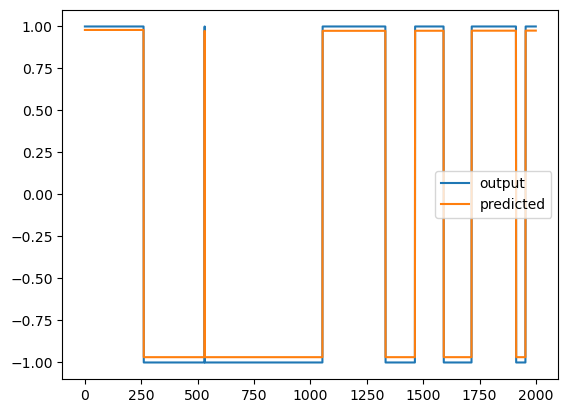

In [677]:
n_start = 0
n_step = 2000
plt.plot(y[n_start:(n_start+n_steps)], label = 'output')
plt.plot(y_out.detach()[n_start:(n_start+n_steps)], label = 'predicted')
plt.legend()
plt.show()

In [678]:
extractor.Win

tensor([[ 0.9242],
        [-1.1574],
        [ 1.4807],
        [ 0.6959]])

In [679]:
# seq_len1 = 2000
# ctrnn = torch.zeros((seq_len1+1, k))
extractor.p

tensor([-0.7000,  1.0000,  0.0000])

In [680]:
extractor.Wp.T

tensor([[0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1000],
        [0.1000, 0.0000, 0.0000, 0.0000]], grad_fn=<PermuteBackward>)

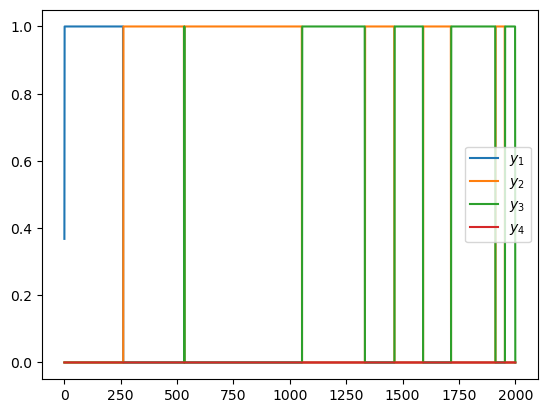

In [681]:
noise1 = 0.01*torch.randn(seq_len+1)
noise2 = 0.01*torch.randn(seq_len+1)
noise3 = 0.01*torch.randn(seq_len+1)
noise4 = 0.01*torch.randn(seq_len+1)
plt.plot(ctrnn.detach()[:, 0] , label='$y_1$')
plt.plot(ctrnn.detach()[:, 1], label='$y_2$')
plt.plot(ctrnn.detach()[:, 2], label='$y_3$')
plt.plot(ctrnn.detach()[:, 3], label='$y_4$')
# plt.plot(u, label='input')
plt.legend()
plt.show()

In [663]:
ix = np.arange(4)
for i in range(ctrnn.shape[0]):
    print(1 + int(ctrnn[i, ix != 1].argmax()), end=' ')
    if i % 50 == 0:
        print('\n')

1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 

2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [606]:
# test set
u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
internal_state = torch.tensor(reservoir.run(u))
u, y = torch.tensor(u), torch.tensor(y)
ctrnn[0] = x_init
h_out, x_curr = extractor.forward(internal_state[0], torch.tensor([1.0]))
ctrnn[1] = x_curr
y_out = torch.zeros_like(y)
y_out[0] = h_out
for t in range(1,seq_len):8
    # y_curr = y_out[t-1]
    u_t = internal_state[t]
    h_out, ctrnn[t+1] = extractor.forward(u_t, h_out)
    y_t = y[t]
    y_out[t] = h_out

plt.plot(y_out.detach(), label = 'predicted')
plt.plot(y, label = 'actual')
plt.legend()
plt.show()

IndentationError: unexpected indent (3402002429.py, line 12)

In [ ]:
N_data =  100
learningRate = 1e-5
optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)
#-------------------- SECOND PASS TO AVOID ZIG-ZAGGING ------------------------#
u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
internal_state = torch.tensor(reservoir.run(u))
for i in range(N_data):
    l = torch.tensor(0.0)
    u, y = torch.tensor(u), torch.tensor(y)
    y_out = torch.zeros_like(y)
    h_out = extractor.forward(u[0], y_curr = y[0])
    y_out[0] = h_out
    y_t = y[0]
    loss = loss_fn(h_out.flatten().float(), y_t.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    for t in range(1,seq_len):
        y_curr = y[t-1]
        u_t = u[t]
        h_out = extractor.forward(u_t, y_curr=y_curr)
        y_t = y[t]
        loss = loss_fn(h_out.flatten().float(), y_t.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l = (l.pow(2) + loss.detach().pow(2)).sqrt()
        y_out[t] = h_out.detach()
    
    print(f'Loss at iteration {i} is {l: .5f}')
    lossHistory.append(l)



n_start = 0
n_steps = 2000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end], label='ena output')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y[n_start:n_end], label = 'output')
plt.legend()
plt.show()

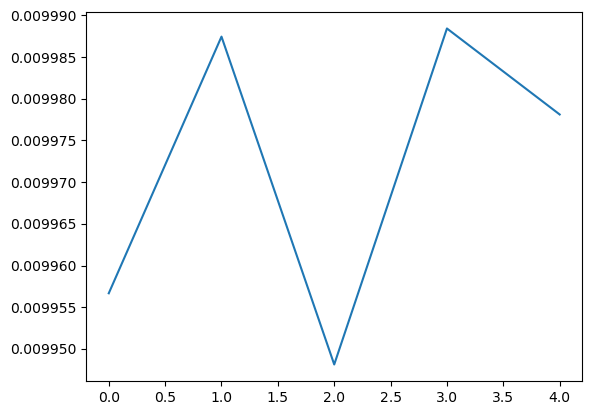

In [664]:
plt.plot(lossHistory)

In [ ]:
# test on a new dataset

seq_len = 2_000
u, y, _ = sequence(seq_len, q, 1, np.random.randint(0, 1e6))
# Wout_readout = torch.tensor(readout.params['Wout'])
# internal_state = torch.tensor(esn.run(u))
# internal_state = torch.tensor(reservoir.run(u))
u, y = torch.tensor(u), torch.tensor(y)
# y_out = torch.zeros((n_out, seq_len))
out = torch.zeros_like(y)
h_out = extractor.forward(u[0], y_curr = torch.zeros((1, n_out)))
out[0] = h_out
# h_out_all = torch.zeros_like((n_out, seq_len))

# Wout_readout = torch.tensor(readout.params['Wout'])
for t in range(1, seq_len):
    h_out = extractor.forward(u[t], y_curr=out[t-1])
    # h_out = extractor.forward(internal_state[t])
    out[t] = h_out
    # y_out_t = torch.matmul(h_out.float(), Wout.float()) + bias
    # y_out[t] = y_out_t
    # out[t] = torch.matmul(h_out.float(), Wout_readout.float())

In [ ]:
n_start = 0
n_steps = 2000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(out.detach().numpy()[n_start:n_end], label='ena output')
# plt.ylim([-1.2, 1.2])
plt.legend()
plt.subplot(2, 1, 2)
# plt.plot(internal_state.detach().numpy()[n_start:n_end, 1], label='actual')
plt.plot(y[n_start:n_end], label = 'output')
# plt.plot(u[n_start:n_end], label = 'input')
plt.legend()
plt.show()

In [ ]:
with open('ena_untrained_params.pkl', 'wb') as f:
    pickle.dump(extractor, f)

In [ ]:
# with a random adjacency matrix
k = 10
n_out = 1
n_in = 1
# n = Wr.shape[0]
graph_seed = 3

A = torch.zeros((k, k))
A[0, 5] = 1
A[1, 4] = 1
A[4, 8] = 1
A[6, [1, 8, 9]] = 1
A[8, 0] = 1
A[9, [2, 5]] = 1
Wp = 0.01*torch.ones((k, k))
beta = torch.tensor(10.0)
# sparsity = 0.5*1/n
# def __init__(self, k, beta_init, p_init, w_p, n_out, A):
scaling = torch.tensor([0.1, 1, 1.0])
extractor = ENA_extractor(k, beta, p, Wp, n_out, n_in, scaling, A)
loss_fn = torch.nn.MSELoss()

G = convert_to_nx(A)
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

In [ ]:
seq_len = 2000
lossHistory = []

In [ ]:
import random
seed = 42
random.seed(seed)
N_data =  10
learningRate = 1e-2

optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)

for i in range(N_data):
    l = torch.tensor(0.0)
    u, y, _ = sequence(seq_len, 0.1, 1, np.random.randint(0, 1e6))
    internal_state = torch.tensor(reservoir.run(u))
    u, y = torch.tensor(u), torch.tensor(y)
    y_out = torch.zeros_like(y)
    y_t = y[0]
    h_out = extractor.forward(u[0], y_curr = torch.zeros((1, n_out)))
    loss = (h_out - y_t).pow(2).sum()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    y_out[0] = h_out
    for t in range(1,seq_len):
        y_curr = y[t-1]
        # y_curr = y_out[t-1]
        h_out = extractor.forward(u[t], y_curr=y_curr)
        y_t = y[t]
        loss = (h_out - y_t).pow(2).sum()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        y_out[t] = h_out


    l = (l.pow(2) + loss.detach().pow(2)).sqrt()
    lossHistory.append(l)
    print(f'Loss at iteration {i} is {l: .4f}')

n_start = 0
n_steps = 1000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end], label='ena output')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y[n_start:n_end], label = 'output')
plt.legend()
plt.show()

Parameter containing:
tensor([ 1.0000, -1.0000,  1.0000, -0.9947], requires_grad=True)

In [ ]:
n_start = 0
n_steps = 1000
d = 0
# plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
# plt.subplot(2, 1, 1)
plt.plot(u[n_start:(n_start + n_steps), d], label = 'input')
# plt.legend()
# plt.show()
# plt.subplot(2, 1, 2)
plt.plot(y[n_start:(n_start + n_steps), d], label='output')
plt.legend()
plt.show()

In [610]:
weight_matrix(extractor.p, extractor.Wp)

TypeError: weight_matrix() missing 1 required positional argument: 'w_p'